In [80]:
using LowRankModels
using PyPlot
using CSV
using Statistics
using LaTeXStrings
using Printf
using ScikitLearn.CrossValidation: KFold

# Load Henry coefficient matrix `H`

see `xxx.ipynb` for Python code that queries the NIST database for the adsorption data and fits Henry's law to the adsorption data to identify the Henry constant.

the gases run along the columns, the materials run along the rows, and the entries are the Henry coefficients identified from experimental adsorption data.

In [2]:
henry_df = CSV.read(joinpath("..", "data", "henry_matrix_df_l_4.csv"))
H = convert(Array{Union{Float64, Missing}, 2}, henry_df[1:end, 2:end])

nm = size(H)[1] # no. of materials
ng = size(H)[2] # no. of gases

# TODO read these in from Python nb
materials = ["mat_$i" for i = 1:nm]
gases = ["gas_$j" for j = 1:ng];

## standardize columns, log10-transform
* take the `log` (base 10) to learn the *order of magnitude* of the Henry coefficients
* standardize the columns (representing $H$'s for a certain gas) so that each column has mean zero and variance of one

In [3]:
# log-10 transform
H = log10.(H)

# standardize the columns
for j = 1:ng
    # find ids that are not missing
    ids = .! ismissing.(H[:, j])
    # Hij <-- (Hij - μ_j) / σ_j 
    H[:, j] .= (H[:, j] .- mean(H[ids, j])) ./ std(H[ids, j])
end

## visualize

here, a diverging colormap is appropriate since the columns are standardized.

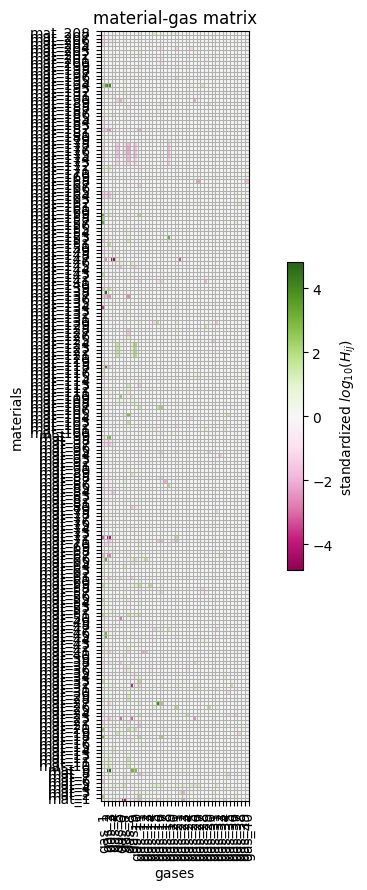

In [166]:
spy_H = deepcopy(H)
spy_H[ismissing.(H)] .= 0.0

fig, ax = subplots(figsize=(10, 10))
pcolormesh(spy_H, cmap="PiYG", 
    vmax=maximum(abs.(spy_H)), vmin=-maximum(abs.(spy_H)))
cbar = colorbar(label=L"standardized $log_{10}(H_{ij})$", shrink=0.4)
grid("on")
ax.set_aspect("equal")
title("material-gas matrix")
xlabel("gases")
ylabel("materials")
xticks(1:ng, gases, rotation=90)
yticks(1:nm, materials);
# TODO xticks, yticks with material and gas names

## work with `H'`, i.e. transpose of `H` to add row offsets via `LowRankModels.jl`

In [173]:
H = collect(H')

40×208 Array{Union{Missing, Float64},2}:
 -0.81472    2.26651    -0.0999175   …  -1.15993   -0.711232    missing 
 -0.385706   0.295079    0.0366868      -0.481756   0.119513    missing 
 -0.48301    0.406198   -0.084839       -0.869534  -0.399304    missing 
   missing   0.0014169   0.402149       -0.674355   0.223363    missing 
 -0.33236    0.40346      missing         missing    missing    missing 
 -0.23438    0.545411     missing    …    missing    missing  -0.0783981
 -4.28304     missing     missing         missing    missing    missing 
 -0.331507    missing   -0.00802385       missing    missing    missing 
 -0.505121   0.126789   -0.225552         missing    missing    missing 
 -0.907     -0.353232    0.379772         missing    missing    missing 
 -1.90057    1.80931    -0.830589    …    missing    missing  -0.594082 
   missing    missing    0.661752         missing    missing    missing 
   missing    missing    0.518981         missing    missing    missing 
  ⋮       

# find the optimal low rank model through cross-validation

In [177]:
ids_obs = observations(H) # returns tuple of observations
nb_obs = length(ids_obs)
println("# observations = ", nb_obs)
println("fraction entries that are filled = ", nb_obs / nm / ng)

# observations = 1176
fraction entries that are filled = 0.14134615384615384


### set up generalized low rank model for practice

we'll train on all data for practice to see how it works.

In [178]:
r = QuadReg(0.01) # quadratic regularizer on X, Y
k = 1 # rank of matrix we seek

glrm = GLRM(H, QuadLoss(), r, r, k, obs=observations(H), offset=true)

X, Y, ch = fit!(glrm) # H ~ X' * Y

@assert isapprox(impute(glrm), X' * Y)

Fitting GLRM
Iteration 10: objective value = 595.3024603586537


### split the observations into `n_folds` folds.

TODO: ask Prof. Udell how this works when a MOF is missing from a row.

In [179]:
n_folds = 5 # K-fold cross validation
println("running $n_folds-cross validation...")
kfolds = KFold(nb_obs, n_folds=n_folds, shuffle=true);

running 5-cross validation...


## run cross-validation

specify the range of ranks and regularization params we aim to cover

In [207]:
ks = [1, 2, 3] # ranks
γs = 10.0 .^ range(0.0, 2.0, length=15); # regularization params

map rank to color for data visualizations

In [208]:
cmap = PyPlot.matplotlib.cm.viridis
norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(ks), vmax=maximum(ks))
rank_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba

PyObject <bound method ScalarMappable.to_rgba of <matplotlib.cm.ScalarMappable object at 0x7ffb3d47db70>>

run `n_folds` cross validation, store test error for each $(k, \gamma)$ combo

In [209]:
# TODO ask Prof. Udell if it makes any sense to regularize X, Y separately
# TODO ask Prof. Udell what the equivalent of k = 0 would be (it fails here)

# progress meter
p = Progress(n_folds * length(ks) * length(γs))

mse = Dict(k => zeros(length(γs)) for k in ks) # store MSE for each regularization param and k

# loop over ranks
for (i_k, k) in enumerate(ks)
    # loop over regularization params
    for (i_γ, γ) in enumerate(γs)
        # loop over folds
        for (train_ids, test_ids) in kfolds
            # train model on training data
            r = QuadReg(γ) # regularizer
            # trick: use H' to add row offsets
            glrm = GLRM(H, QuadLoss(), r, r, k, obs=ids_obs[train_ids], offset=true)
            X, Y, ch = fit!(glrm, verbose=false) # H ~ X' * Y
            
            # assess error on test data
            Ĥ = impute(glrm)
            H_pred = [Ĥ[i, j] for (i, j) in ids_obs[test_ids]]
            H_actual = [H[i, j] for (i, j) in ids_obs[test_ids]]
            mse[k][i_γ] += sum((H_pred .- H_actual) .^ 2) / length(test_ids)
            ProgressMeter.next!(p)
        end
    end
    mse[k] /= n_folds
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


visualize average `n_fold` test set error against regularization param $\gamma$ for different ranks

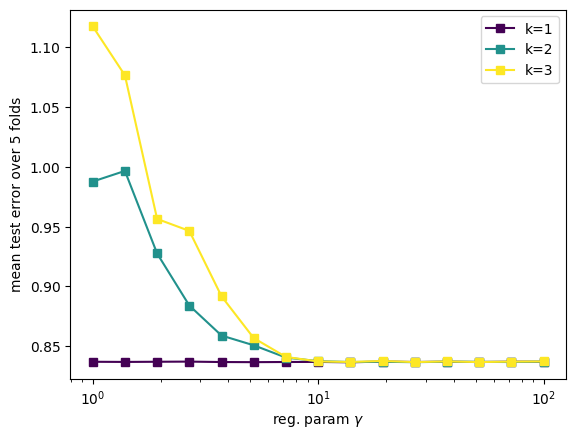

PyObject <matplotlib.legend.Legend object at 0x7ffb3d3c1898>

In [210]:
figure()
xlabel(L"reg. param $\gamma$")
ylabel("mean test error over $n_folds folds")
for k in ks
    plot(γs, mse[k], label="k=$k", marker="s", color=rank_to_color(k))
end
xscale("log")
legend()

## work with optimal model

In [211]:
min_mse = [minimum(mse[k]) for k in ks]
opt_k = ks[argmin(min_mse)] # optimum rank
opt_γ = γs[argmin(mse[opt_k])]

@printf("optimum γ = %.3f, optimum k = %d\n", opt_γ, opt_k)

optimum γ = 13.895, optimum k = 1


### parity plot over `n_folds`-cross validation

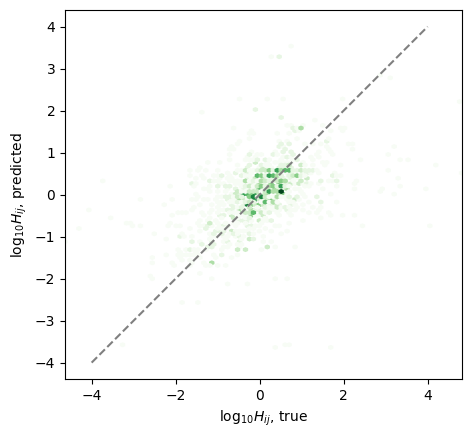

0-element Array{Any,1}

In [212]:
H_actual = Float64[]
H_pred = Float64[]
for (train_ids, test_ids) in kfolds
    # train model on training data
    r = QuadReg(opt_γ) # regularizer
    glrm = GLRM(H, QuadLoss(), r, r, opt_k, obs=ids_obs[train_ids], offset=true)
    X, Y, ch = fit!(glrm, verbose=false) # H ~ X' * Y
    
    # test
    Ĥ = impute(glrm)
    H_pred = vcat(H_pred, [Ĥ[i, j] for (i, j) in ids_obs[test_ids]])
    H_actual = vcat(H_actual, [H[i, j] for (i, j) in ids_obs[test_ids]])
end

fig, ax = subplots()
xlabel(L"$\log_{10} H_{ij}$, true")
ylabel(L"$\log_{10} H_{ij}$, predicted")
hexbin(H_actual, H_pred, cmap="Greens", mincnt=1) #mincnt=1 makes bins white
ax.set_aspect("equal")
plot([-4, 4], [-4, 4], linestyle="--", color="gray")
plot()

## viz offsets and latent space on fully trained model

In [213]:
r = QuadReg(opt_γ) # regularizer
glrm = GLRM(H, QuadLoss(), r, r, opt_k, obs=ids_obs, offset=true)
X, Y, ch = fit!(glrm, verbose=false) # H ~ X' * Y

([1.0 1.0 … 1.0 1.0], [-1.0334396346391046 0.5702423022566232 … -0.19155356925786046 0.36279703593803586], ConvergenceHistory("ProxGradGLRM", [Inf, 1402.5531114350713, 1133.1292567440003, 884.1366978283478, 762.5110339415003, 659.6906327845894, 609.6116643541517, 599.4817737427213, 596.7540516449423, 595.8703157047298, 595.2969152711296, 594.865638599959, 594.5667688774514, 594.4008754507978, 594.3679741009563], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0020608901977539062, 0.011324882507324219, 0.01464986801147461, 0.016489744186401367, 0.01837778091430664, 0.0205538272857666, 0.022545814514160156, 0.024568796157836914, 0.0456547737121582, 0.04912877082824707, 0.051181793212890625, 0.053044795989990234, 0.055046796798706055, 0.05683779716491699], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0))

### offsets $\mu_i$ representing material biases

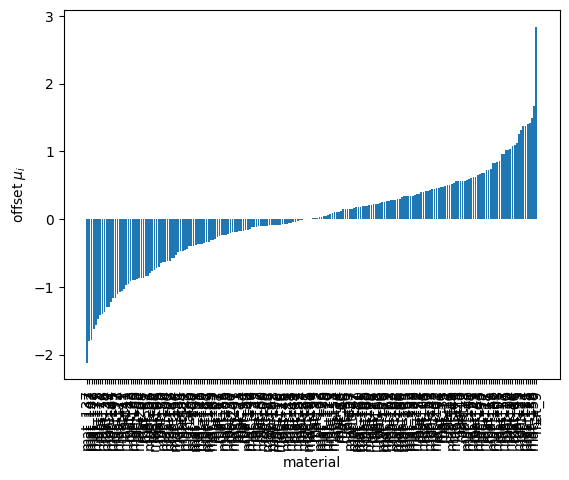

In [214]:
μ = Y[end, :]

figure()
bar(1:nm, μ[sortperm(μ)])
xlabel("material")
ylabel(L"offset $\mu_i$")
xticks(1:nm, materials[sortperm(μ)], rotation=90);

### latent space of materials